In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics.pairwise import pairwise_kernels
import sklearn.model_selection as model_selection
from sklearn.metrics import mean_squared_error
import uncertainty_sampling_multiclass as usm
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("forestfires.csv")

In [3]:
df = pd.get_dummies(df, prefix=['month_', 'day_'])

In [4]:
data = df.values
print(data.shape)

(517, 30)


In [5]:
X = np.array(data[:, :-1], dtype = float)

In [6]:
Y = np.array(data[:, -1:], dtype = float)

In [7]:
print(X.dtype)
print(Y.dtype)

float64
float64


In [8]:
def normalize(x):
    dim = x.shape[1]
    x_min = np.min(x, axis = 0, keepdims = True)
    x_max = np.max(x, axis = 0, keepdims = True)
    inds = x_max - x_min == 0
    norm = x_max - x_min
    norm[inds] = 1.0
    return np.divide(x - x_min, norm)

In [9]:
X = normalize(X)

In [10]:
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, train_size=0.80, test_size=0.20, random_state=0)

In [11]:
linear = LinearRegression().fit(X_train, Y_train)
rbf = KernelRidge(alpha = 0.1, kernel = 'rbf').fit(X_train, Y_train)
poly = KernelRidge(alpha = 1.0, kernel = 'poly').fit(X_train, Y_train)

In [12]:
linear_pred = linear.predict(X_test)
rbf_pred = rbf.predict(X_test)
poly_pred = poly.predict(X_test)

In [13]:
linear_mse = mean_squared_error(Y_test, linear_pred)
print('MSE (Linear): ', "%.2f" % (linear_mse))

MSE (Linear):  0.00


In [14]:
rbf_mse = mean_squared_error(Y_test, rbf_pred)
print('MSE (Rbf): ', "%.2f" % (rbf_mse))

MSE (Rbf):  0.01


In [15]:
poly_mse = mean_squared_error(Y_test, poly_pred)
print('MSE (Polynomial): ', "%.2f" % (poly_mse))

MSE (Polynomial):  0.04


In [16]:
linear = LinearRegression().fit(X_train, np.log1p(Y_train))
rbf = KernelRidge(alpha = 0.1, kernel = 'rbf').fit(X_train, np.log1p(Y_train))
poly = KernelRidge(alpha = 1.0, kernel = 'poly').fit(X_train, np.log1p(Y_train))

In [17]:
linear_pred = np.exp(linear.predict(X_test)) - 1.0
rbf_pred = np.exp(rbf.predict(X_test)) - 1.0
poly_pred = np.exp(poly.predict(X_test)) - 1.0

In [18]:
linear_mse = mean_squared_error(Y_test, linear_pred)
print('MSE (Linear): ', "%.2f" % (linear_mse))

MSE (Linear):  0.00


In [19]:
rbf_mse = mean_squared_error(Y_test, rbf_pred)
print('MSE (Rbf): ', "%.2f" % (rbf_mse))

MSE (Rbf):  0.01


In [20]:
poly_mse = mean_squared_error(Y_test, poly_pred)
print('MSE (Polynomial): ', "%.2f" % (poly_mse))

MSE (Polynomial):  0.05


In [35]:
coeff_pas, inter_pas = usm.uncertain_sampling(X_train, np.log1p(Y_train), 
                           init = 'zero', 
                           query = 'passive',
                           max_iter = 4e2, 
                           step_size = 1e-2, 
                           batch_size = 4,
                           method = 'linear_regression')

100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 12501.65it/s]


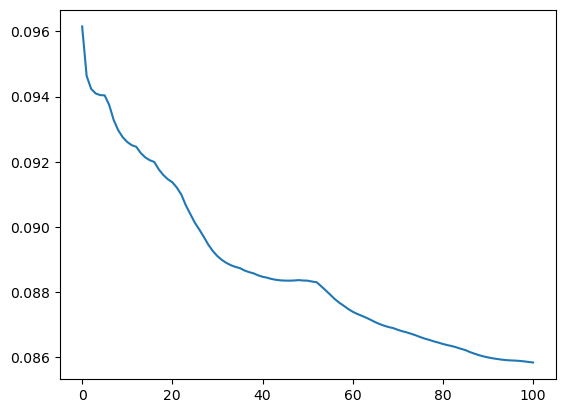

In [36]:
loss_pas = usm.plot_loss(X_test, Y_test, coeff_pas, inter_pas, is_print = True, log_transform = True)

In [37]:
coeff_act, inter_act = usm.uncertain_sampling(X_train, np.log1p(Y_train), 
                           init = 'zero', 
                           query = 'active',
                           width = 2e-1,
                           max_iter = 4e2, 
                           step_size = 1e-2, 
                           warm_start = 0,
                           sep_valid = True,
                           valid_ratio = 1.0,
                           update_freq = 1,
                           batch_size = 4,
                           method = 'linear_regression')

100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 3337.87it/s]


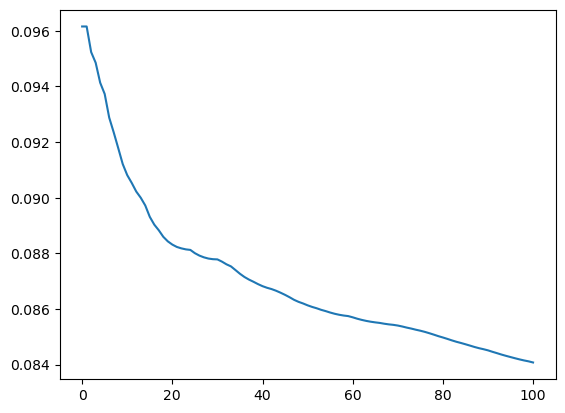

In [38]:
loss_act = usm.plot_loss(X_test, Y_test, coeff_act, inter_act, is_print = True, log_transform = True)

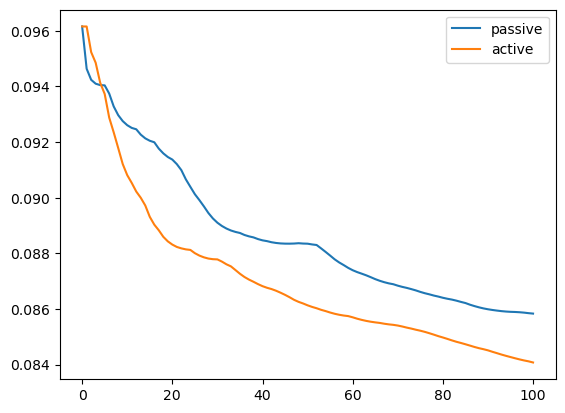

In [39]:
plt.plot(loss_pas, label = 'passive')
plt.plot(loss_act, label = 'active')
plt.legend()
plt.show()

In [47]:
trials = 30
steps = 400
batch_size = 4
is_first = True
for t in range(trials):
    print("************************\n trial", t + 1)
    X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, train_size=0.80, test_size=0.20)
    init = np.random.normal(size = (X_train.shape[1] + 1, 1), scale = 1e-1)
    coeff_pas, inter_pas = usm.uncertain_sampling(X_train, np.log1p(Y_train),
                                              init_method = 'fixed',
                                              init = np.copy(init), 
                                              query = 'passive',
                                              max_iter = steps, 
                                              step_size = 1e-2, 
                                              batch_size = batch_size,
                                              method = 'linear_regression')
    coeff_act, inter_act = usm.uncertain_sampling(X_train, np.log1p(Y_train),
                                              init_method = 'fixed',
                                              init = np.copy(init), 
                                              query = 'active',
                                              width = 2e-1,
                                              max_iter = steps, 
                                              step_size = 1e-2, 
                                              warm_start = 0,
                                              sep_valid = True,
                                              valid_ratio = 1.0,
                                              update_freq = 1,
                                              batch_size = batch_size,
                                              method = 'linear_regression')
    if is_first:
        loss_pas = np.asarray(usm.plot_loss(X_test, Y_test, coeff_pas, inter_pas, log_transform = True)) / float(trials)
        loss_act = np.asarray(usm.plot_loss(X_test, Y_test, coeff_act, inter_act, log_transform = True)) / float(trials)
        is_first = False
    else:
        loss_pas += np.asarray(usm.plot_loss(X_test, Y_test, coeff_pas, inter_pas, log_transform = True)) / float(trials)
        loss_act += np.asarray(usm.plot_loss(X_test, Y_test, coeff_act, inter_act, log_transform = True)) / float(trials)

************************
 trial 1


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 3610.21it/s]


************************
 trial 2


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 3431.88it/s]


************************
 trial 3


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 3342.69it/s]


************************
 trial 4


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 3418.79it/s]


************************
 trial 5


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 3272.68it/s]


************************
 trial 6


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 3403.91it/s]


************************
 trial 7


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 3430.90it/s]


************************
 trial 8


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 3403.00it/s]


************************
 trial 9


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2986.44it/s]


************************
 trial 10


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 3533.68it/s]


************************
 trial 11


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 3418.95it/s]


************************
 trial 12


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 3484.71it/s]


************************
 trial 13


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 3329.79it/s]


************************
 trial 14


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 4305.47it/s]


************************
 trial 15


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2997.67it/s]


************************
 trial 16


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 3538.24it/s]


************************
 trial 17


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 3535.02it/s]


************************
 trial 18


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 3353.67it/s]


************************
 trial 19


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 3554.19it/s]


************************
 trial 20


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 3474.38it/s]


************************
 trial 21


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 3749.07it/s]


************************
 trial 22


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 3410.53it/s]

************************
 trial 23



100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 3382.45it/s]


************************
 trial 24


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 3915.30it/s]


************************
 trial 25


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 4120.91it/s]


************************
 trial 26


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 3386.55it/s]


************************
 trial 27


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 3523.59it/s]


************************
 trial 28


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 3587.94it/s]


************************
 trial 29


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 3690.32it/s]


************************
 trial 30


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 3527.62it/s]


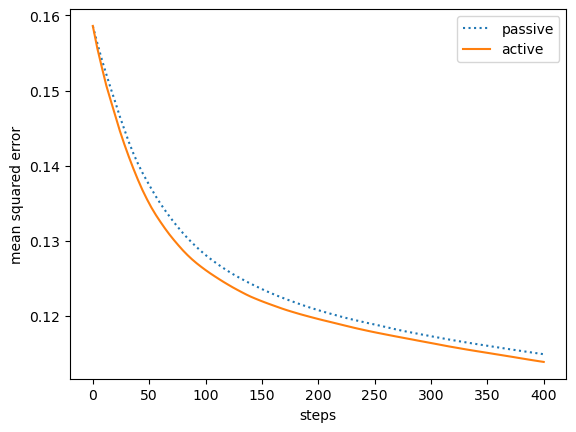

In [48]:
grid = np.arange(0, steps, batch_size)
grid = np.concatenate((grid, np.atleast_1d(steps)))
plt.plot(grid, loss_pas, label = 'passive', linestyle = 'dotted')
plt.plot(grid, loss_act, label = 'active', linestyle = 'solid')
plt.legend()
plt.xlabel('steps')
plt.ylabel('mean squared error')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


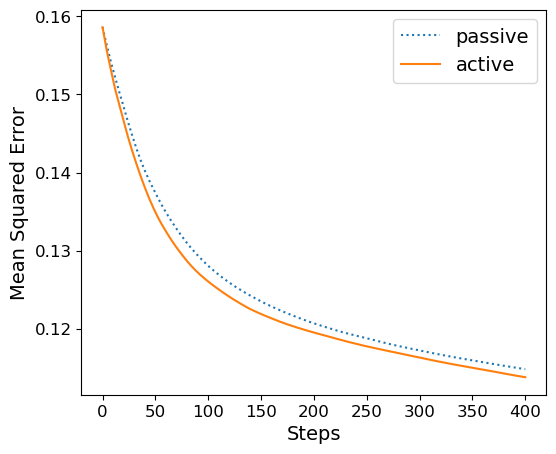

In [50]:
fig, ax = plt.subplots(1, 1, figsize = (6, 5))

ax.plot(grid, loss_pas, label = 'passive', linestyle = 'dotted')
ax.plot(grid, loss_act, label = 'active', linestyle = 'solid')


ax.legend(fontsize=14)
ax.set_xlabel('Steps', fontsize=14)
ax.set_ylabel('Mean Squared Error', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=12)

plt.savefig("Exp2_forestfires.jpg", bbox_inches='tight')
plt.savefig("Exp2_forestfires.eps", bbox_inches='tight')
plt.show()